# 1. Set Up

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import pydotplus

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os.path

# Import dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Initialize the number of epochs and batch size
NUM_EPOCHS = 10
BS = 32

# 2. Pre-processing

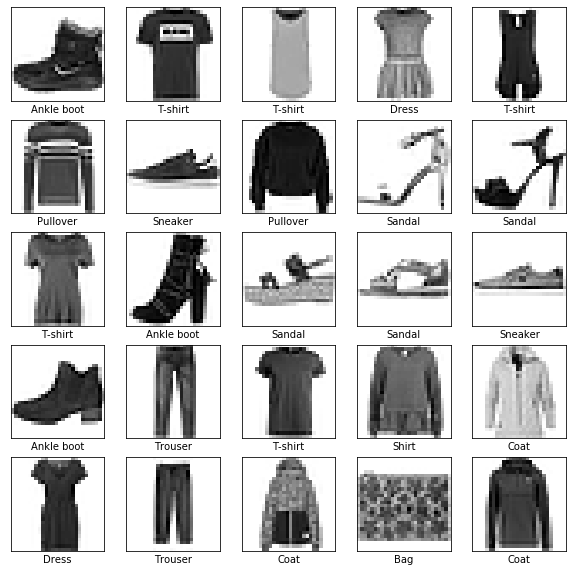

In [2]:
# Classification labeling
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
NUM_CLASSES = len(class_names)

# Plot sample data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Pre-processing scaling
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
train_images = train_images / 255.0
test_images = test_images / 255.0

# 3. Define 2 CNN Architectures

## 3.1 LeNet-5-inspired Architecture

| Layer | Input | Output | Note |
| --- | --- | --- | --- |
| **Convolution 1** | 28x28x1 | 28x28x6 | Filters = 6 ; Kernel size = 5x5 |
| **MaxPooling 1** | 28x28x6 | 14x14x6 | Size = 2x2 ; Drop out = 0.25 |
| **Convolution 2** | 14x14x6 | 10x10x16 | Filters = 16 ; Kernel size = 5x5 |
| **MaxPooling 2** | 10x10x16 | 5x5x16 | Size = 2x2 ; Drop out = 0.25 |
| **Fully Connected 1** | 5x5x16 | 120 | Drop out = 0.5 |
| **Fully Connected 2** | 120 | 84 | |
| **Output** | 84 | 10 | |

**Changes from original LeNet-5 Architecture:**
* Input size is `28x28` instead of `32x32`
* `Max Pooling` instead of `Average Pooling`
* `ReLu Activation` instead of `tanh`

In [3]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = tf.keras.Sequential()
        inputShape = (height, width, depth)
   
        # 1st CONV => RELU => POOL layer
        model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='relu', input_shape=inputShape)) 
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Dropout(0.25))
        # 2nd CONV => RELU => POOL layer
        model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Dropout(0.25))
        # 1st FC => RELU layer
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(120, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        # 2nd FC => RELU layer
        model.add(tf.keras.layers.Dense(84, activation='relu'))
        # Output layer
        model.add(tf.keras.layers.Dense(classes, activation='softmax'))
 
        # return the constructed network architecture
        return model

## 3.2 VGG16-inspired Architecture (MiniVGGNet)
*Source: https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/*


| Layer | Input | Output | Note |
| --- | --- | --- | --- |
| **Convolution 1.1** | 28x28x1 | 28x28x32 | Filters = 32 ; Kernel size = 3x3 |
| **Convolution 1.2** | 28x28x32 | 28x28x32 | Filters = 32 ; Kernel size = 3x3 |
| **MaxPooling 1** | 28x28x32 | 14x14x32 | Size = 2x2 ; Drop out = 0.25 |
| **Convolution 2.1** | 14x14x32 | 14x14x64 | Filters = 16 ; Kernel size = 3x3 |
| **Convolution 2.2** | 14x14x64 | 14x14x64 | Filters = 6 ; Kernel size = 3x3 |
| **MaxPooling 2** | 14x14x64 | 7x7x64 | Size = 2x2 ; Drop out = 0.25 |
| **Fully Connected 1** | 7x7x64 | 512 | Drop out = 0.5 |
| **Output** | 512 | 10 | |

**Changes from original VGG16 Architecture:**
* Only 2 sets of `(Conv + ReLU)*2 + Pool`
* Only 1 `Fully Connected (Dense)` layer
* No `Batch Normalisation`

In [4]:
# MiniVGGNet: (CONV => RELU => CONV => RELU => POOL)*2 => FC => RELU
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = tf.keras.Sequential()
        inputShape = (height, width, depth)
   
        # 1st CONV => RELU => CONV => RELU => POOL layer
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=inputShape)) 
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Dropout(0.25))
        # 2nd CONV => RELU => CONV => RELU => POOL layer
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        model.add(tf.keras.layers.Dropout(0.25))
        # 1st FC => RELU layer
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        # Output layer
        model.add(tf.keras.layers.Dense(classes, activation='softmax'))
 
        # return the constructed network architecture
        return model

# 4. Building & Training Models

## 4.1 LeNet Model

In [5]:
# Build model
model_LeNet = LeNet.build(width=28, height=28, depth=1, classes=NUM_CLASSES)

# Take a look at the models summary
print("LeNet")
model_LeNet.summary()

LeNet
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)          

In [6]:
# Train the model (if weight file not exists)
if os.path.isfile('LeNet_weights.h5') == False:
    # Train
    model_LeNet.fit(x=train_images, y=train_labels,
          batch_size=BS,
          epochs=NUM_EPOCHS)
    
    # Save the weights
    model_LeNet.save_weights('LeNet_weights.h5')

    # Save the model architecture
    with open('LeNet_architecture.json', 'w') as f:
        f.write(model_LeNet.to_json())
else:
    # Load architecture
    with open('LeNet_architecture.json', 'r') as f:
        model_LeNet = tf.keras.models.model_from_json(f.read())
    # Load pre-trained weight
    model_LeNet.load_weights('LeNet_weights.h5')
    
# Compile the model
model_LeNet.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## 4.2 MiniVGGNet Model

In [7]:
# Build model
model_VGG = MiniVGGNet.build(width=28, height=28, depth=1, classes=NUM_CLASSES)

# Take a look at the models summary
print("MiniVGGNet")
model_VGG.summary()

MiniVGGNet
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 6

In [8]:
# Train the model (if weight file not exists)
if os.path.isfile('MiniVGG_weights.h5') == False:
    # Train
    model_VGG.fit(x=train_images, y=train_labels,
          batch_size=BS,
          epochs=NUM_EPOCHS)
    
    # Save the weights
    model_VGG.save_weights('MiniVGG_weights.h5')

    # Save the model architecture
    with open('MiniVGG_architecture.json', 'w') as f:
        f.write(model_MiniVGG.to_json())
else:
    # Load architecture
    with open('MiniVGG_architecture.json', 'r') as f:
        model_VGG = tf.keras.models.model_from_json(f.read())
    # Load pre-trained weight
    model_VGG.load_weights('MiniVGG_weights.h5')

# Compile the model
model_VGG.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 5. Testing & Report

In [14]:
from sklearn.metrics import classification_report

# Define report module
def report(model, test_images, test_labels):
    # Evaluate the model on test set
    print('='*60)
    print('Classification Report')
    preds = model.predict(test_images)
    print(classification_report(test_labels, preds.argmax(axis=1), target_names=class_names))

    # Print test accuracy
    score = model.evaluate(test_images, test_labels, verbose=0)
    print('='*60)
    print('Test accuracy:', score[1])
    print('Loss score:',score[0])
    
    # Visualise 25 random test predictions
    print('\n'+'='*60)
    print('Random test visualization')
    output_images = {'images':[], 'labels':[], 'label_colors':[]}
    
    for i in np.random.choice(np.arange(0, len(test_labels)), size=(25,)):
        # classify the clothing
        probs = model.predict(test_images[np.newaxis, i])
        prediction = probs.argmax(axis=1)
        label = class_names[prediction[0]]
        image = (test_images[i] * 255).astype("uint8")
        
        # initialize the text label color as green (correct)
        color = 'green'
 
        # otherwise, the class label prediction is incorrect
        if prediction[0] != test_labels[i]:
            color = 'red'
            label = class_names[prediction[0]] + ' (' + class_names[test_labels[i]] + ')'
        
        # append to output
        output_images['images'].append(image.reshape(28,28))
        output_images['labels'].append(label)
        output_images['label_colors'].append(color)
        
    # visualise output
    fig = plt.figure(figsize=(10,10))
    for i in range(25):
        ax = fig.add_subplot(5,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(output_images['images'][i], cmap=plt.cm.binary)
        ax.set_xlabel(output_images['labels'][i])
        ax.xaxis.label.set_color(output_images['label_colors'][i])
    plt.show()
    
    return

## 5.1 LeNet Model Report

LeNet Report
Classification Report
              precision    recall  f1-score   support

     T-shirt       0.86      0.85      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.84      0.82      0.83      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.79      0.85      0.82      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.73      0.70      0.71      1000
     Sneaker       0.92      0.99      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Test accuracy: 0.8975
Loss score: 0.28615895509719846

Random test visualization


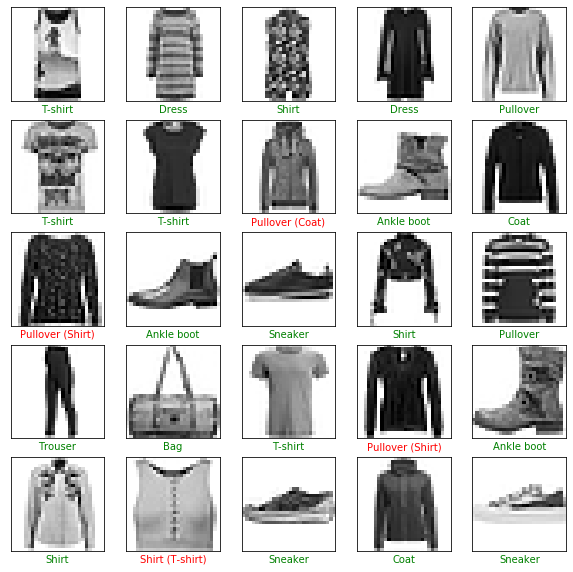

In [10]:
print('LeNet Report')
report(model_LeNet, test_images, test_labels)

## 5.2 MiniVGG Model Report

MiniVGG Report
Classification Report
              precision    recall  f1-score   support

     T-shirt       0.88      0.86      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.90      0.89      1000
       Dress       0.92      0.95      0.94      1000
        Coat       0.89      0.88      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.79      0.77      0.78      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Test accuracy: 0.9273
Loss score: 0.20727913785278798

Random test visualization


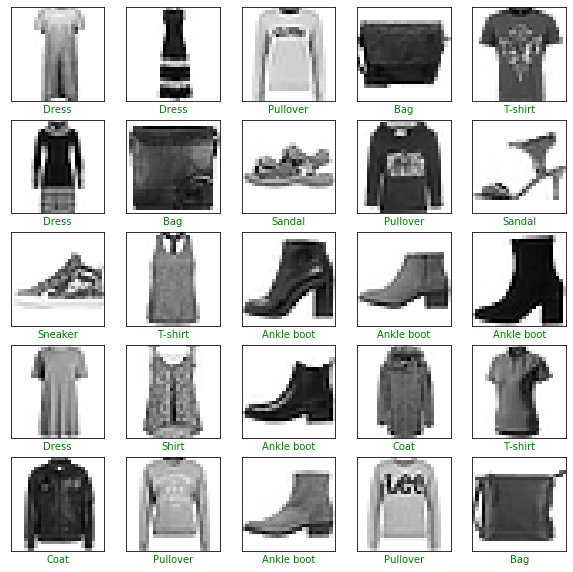

In [11]:
print('MiniVGG Report')
report(model_VGG, test_images, test_labels)